#**PROBLEMA DE NEGOCIO**


---




La importancia de reducir el riesgo crediticio ha llevado a una institución financiera alemana a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para construir un modelo de machine learning preciso y confiable que sea capaz de evaluar con mayor precisión la probabilidad de incumplimiento crediticio de sus clientes.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Realizar limpieza de datos, manejar valores faltantes, codificación de variables categóricas y normalización/escalado de datos.

**2. Exploración de Datos:** Analizar y comprender el conjunto de datos proporcionado, identificar variables llaves y realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Regresión Logística, Árboles de Decisión, Random Forest, Naive Bayes, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como precisión, recall, área bajo la curva ROC, y F1-score. Seleccionar el modelo con el mejor rendimiento para la predicción de la solvencia crediticia.

#**1. Configuración del Ambiente**


---




In [74]:
import pandas as pd
import json
pd.set_option('display.max_columns', None) #muestra todas las columnas de un dataframe.
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") #se filtran las advertencias para que no sean mostradas a través de warnings.
from sklearn.model_selection import train_test_split #divide un conjunto de datos en conjunto de entrenamiento y prueba.
from sklearn.linear_model import LogisticRegression #implementa modelos de regresion logistica para problemas de clasificacion binaria.
from sklearn.tree import DecisionTreeClassifier #implementar modelos de arboles de decisión para clasificación.
from sklearn.ensemble import RandomForestClassifier #implementación de un conjunto de arboles de decisión conocido como bosque aleatorio.
from sklearn.naive_bayes import GaussianNB #implementa clasificador de Naive Bayes
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #importa varias metricas de evaluacion de modelos de clasificación: precisión global, precisión, exhaustividad
from sklearn.metrics import roc_auc_score, roc_curve #Puntuacion F1, area bajo la curva y roc_curve genera los puntos de la curva ROC.
from imblearn.over_sampling import SMOTE #libreria para balancear datos

global df_banco, resultados  #variables globales

#**2. Preprocesamiento de Datos**


---


In [75]:
df_banco = pd.read_csv("german_credit.csv")
df_banco.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,other_debtors,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,none,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,none,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,none,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,guarantor,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,none,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [76]:
#dataframe original
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

In [77]:
#función procesar_datos()
def procesar_datos():
    global df_banco, resultados

    #eliminar duplicados
    df_banco=df_banco.drop_duplicates()

    #crear diccionario de datos
    diccionario1='''
    {
      "default": {
        "Good customer": 0,
        "Bad customer": 1
      },
      "account_check_status": {
        "< 0 DM": 1,
        "0 <= ... < 200 DM": 2,
        ">= 200 DM / salary assignments for at least 1 year": 3,
        "no checking account": 4
      },
      "credit_history": {
        "no credits taken/ all credits paid back duly": 1,
        "all credits at this bank paid back duly": 2,
        "existing credits paid back duly till now": 3,
        "delay in paying off in the past": 4,
        "critical account/ other credits existing (not at this bank)": 5
      },
      "purpose": {
        "car (new)": 1,
        "car (used)": 2,
        "furniture/equipment": 3,
        "radio/television": 4,
        "domestic appliances": 5,
        "repairs": 6,
        "education": 7,
        "(vacation - does not exist?)": 8,
        "retraining": 9,
        "business": 10,
        "others": 11
      },
      "savings": {
        "... < 100 DM": 5,
        "100 <= ... < 500 DM": 4,
        "500 <= ... < 1000 DM ": 3,
        ".. >= 1000 DM ": 2,
        "unknown/ no savings account": 1
      },
      "present_emp_since": {
        "unemployed": 5,
        "... < 1 year ": 4,
        "1 <= ... < 4 years": 3,
        "4 <= ... < 7 years": 2,
        ".. >= 7 years": 1
      },
      "personal_status_sex": {
        "male : divorced/separated": 1,
        "female : divorced/separated/married": 2,
        "male : single": 3,
        "male : married/widowed": 4,
        "female : single": 5
      },
      "other_debtors": {
        "none": 1,
        "co-applicant": 2,
        "guarantor": 3
      },
      "property": {
        "real estate": 1,
        "if not A121 : building society savings agreement/ life insurance": 2,
        "if not A121/A122 : car or other, not in attribute 6": 3,
        "unknown / no property": 4
      },
      "other_installment_plans": {
        "bank": 1,
        "stores": 2,
        "none": 3
      },
      "housing": {
        "rent": 1,
        "own": 2,
        "for free": 3
      },
      "job": {
        "unemployed/ unskilled - non-resident": 1,
        "unskilled - resident": 2,
        "skilled employee / official": 3,
        "management/ self-employed/ highly qualified employee/ officer": 4
      },
      "telephone": {
        "none": 0,
        "yes, registered under the customers name ": 1
      },
      "foreign_worker": {
        "yes": 1,
        "no": 0
      }
    }
    '''
    mapeo = json.loads(diccionario1)
    #definimos las columnas a mapear
    columnas_a_mapear = ['account_check_status', 'credit_history' , 'purpose', 'savings', 'present_emp_since', 'personal_status_sex', 'other_debtors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

    #iteramos por el dataframe df_banco
    for columna in columnas_a_mapear:
        df_banco[columna] = df_banco[columna].map(mapeo[columna])


In [78]:
procesar_datos()
df_banco.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,other_debtors,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,1,6,5,5,1169,1,1,4,3,1,4,1,67,3,2,2,3,1,1,1
1,1,2,48,3,5,5951,5,3,2,2,1,2,1,22,3,2,1,3,1,0,1
2,0,4,12,5,8,2096,5,2,2,3,1,3,1,49,3,2,1,2,2,0,1
3,0,1,42,3,4,7882,5,2,2,3,3,4,2,45,3,3,1,3,2,0,1
4,1,1,24,4,1,4870,5,3,3,3,1,4,4,53,3,3,2,3,2,0,1


In [79]:
# verificar valores unicos
valores_unicos = df_banco['personal_status_sex'].unique()

# Crea un diccionario de mapeo
diccionario_mapeo = {valor: indice for indice, valor in enumerate(valores_unicos)}

# Imprime el diccionario
print(diccionario_mapeo)


{3: 0, 2: 1, 1: 2, 4: 3}


In [80]:
#verificar que todos los campos sean numericos
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   default                     1000 non-null   int64
 1   account_check_status        1000 non-null   int64
 2   duration_in_month           1000 non-null   int64
 3   credit_history              1000 non-null   int64
 4   purpose                     1000 non-null   int64
 5   credit_amount               1000 non-null   int64
 6   savings                     1000 non-null   int64
 7   present_emp_since           1000 non-null   int64
 8   installment_as_income_perc  1000 non-null   int64
 9   personal_status_sex         1000 non-null   int64
 10  other_debtors               1000 non-null   int64
 11  present_res_since           1000 non-null   int64
 12  property                    1000 non-null   int64
 13  age                         1000 non-null   int64
 14  other_ins

#**3. Exploración de Datos**


---


In [81]:
variables_discretas = ['personal_status_sex', 'age', 'duration_in_month', 'credit_amount', 'default']
df_banco[variables_discretas].head()

,personal_status_sex,age,duration_in_month,credit_amount,default
0,3,67,6,1169,0
1,2,22,48,5951,1
2,3,49,12,2096,0
3,3,45,42,7882,0
4,3,53,24,4870,1


In [82]:
#función feature_engineering()
def feature_engineering():
  global df_banco, resultados  #variables globales

  map_sexo = {2: 1, 5:1, 1: 0, 3: 0, 4: 0}
  df_banco['sexo'] = df_banco['personal_status_sex'].map(map_sexo)

  map_estado_civil={3: 1, 5: 1, 1: 0, 2: 0,4: 0}
  df_banco['estado_civil'] = df_banco['personal_status_sex'].map(map_estado_civil)

  df_banco['rango_edad'] = pd.cut(x = df_banco['age'], bins=[18, 30, 40, 50, 60, 70, 80], labels = [1, 2, 3, 4, 5, 6])

  df_banco['rango_plazos_credito'] = pd.cut(x = df_banco['duration_in_month'], bins=[1, 12, 24, 36, 48, 60, 72], labels = [1, 2, 3, 4, 5,6])

  bins = [i for i in range(0, 21000, 1000)]
  labels = [i for i in range(1, 21)]
  df_banco['rango_valor_credito'] = pd.cut(x=df_banco['credit_amount'], bins=bins, labels=labels, include_lowest=True)

  #columnas a eliminar
  columnas_eliminar = ['personal_status_sex', 'age','duration_in_month', 'credit_amount']
  df_banco = df_banco.drop(columns=columnas_eliminar)

  #cambiando el tipo de datos a int
  df_banco['rango_edad'] = df_banco['rango_edad'].astype(int)
  df_banco['rango_plazos_credito'] = df_banco['rango_plazos_credito'].astype(int)
  df_banco['rango_valor_credito'] = df_banco['rango_valor_credito'].astype(int)



In [83]:
feature_engineering()
df_banco.head()

,default,account_check_status,credit_history,purpose,savings,present_emp_since,installment_as_income_perc,other_debtors,present_res_since,property,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,sexo,estado_civil,rango_edad,rango_plazos_credito,rango_valor_credito
0,0,1,5,5,1,1,4,1,4,1,3,2,2,3,1,1,1,0,1,5,1,2
1,1,2,3,5,5,3,2,1,2,1,3,2,1,3,1,0,1,1,0,1,4,6
2,0,4,5,8,5,2,2,1,3,1,3,2,1,2,2,0,1,0,1,3,1,3
3,0,1,3,4,5,2,2,3,4,2,3,3,1,3,2,0,1,0,1,3,4,8
4,1,1,4,1,5,3,3,1,4,4,3,3,2,3,2,0,1,0,1,4,2,5


In [84]:
#verificar que todos los campos sean numericos
df_banco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   default                     1000 non-null   int64
 1   account_check_status        1000 non-null   int64
 2   credit_history              1000 non-null   int64
 3   purpose                     1000 non-null   int64
 4   savings                     1000 non-null   int64
 5   present_emp_since           1000 non-null   int64
 6   installment_as_income_perc  1000 non-null   int64
 7   other_debtors               1000 non-null   int64
 8   present_res_since           1000 non-null   int64
 9   property                    1000 non-null   int64
 10  other_installment_plans     1000 non-null   int64
 11  housing                     1000 non-null   int64
 12  credits_this_bank           1000 non-null   int64
 13  job                         1000 non-null   int64
 14  people_un

In [85]:
#función analisis_exploratorio()
def analisis_exploratorio():
  global df_banco, resultados  #variables globales

  #estilo para seaborn
  sns.set(style="whitegrid")

  histograma = ['sexo', 'estado_civil', 'rango_plazos_credito', 'rango_edad', 'default']
  nrows=3
  ncols=2
  fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

  # Histogramas
  k = 0
  for i in range(nrows):
      for j in range(ncols):
          atributo = histograma[k]
          sns.countplot(data=df_banco, x=atributo, palette='bright', ax=axs[i, j])
          axs[i, j].set_ylabel('Total')
          k += 1
          if k >= len(histograma):
              break
  #eliminar eje vacio
  if len(histograma) % 2 != 0:
        fig.delaxes(axs[-1, -1])

  # Dibujar histogramas
  plt.tight_layout()
  plt.show()





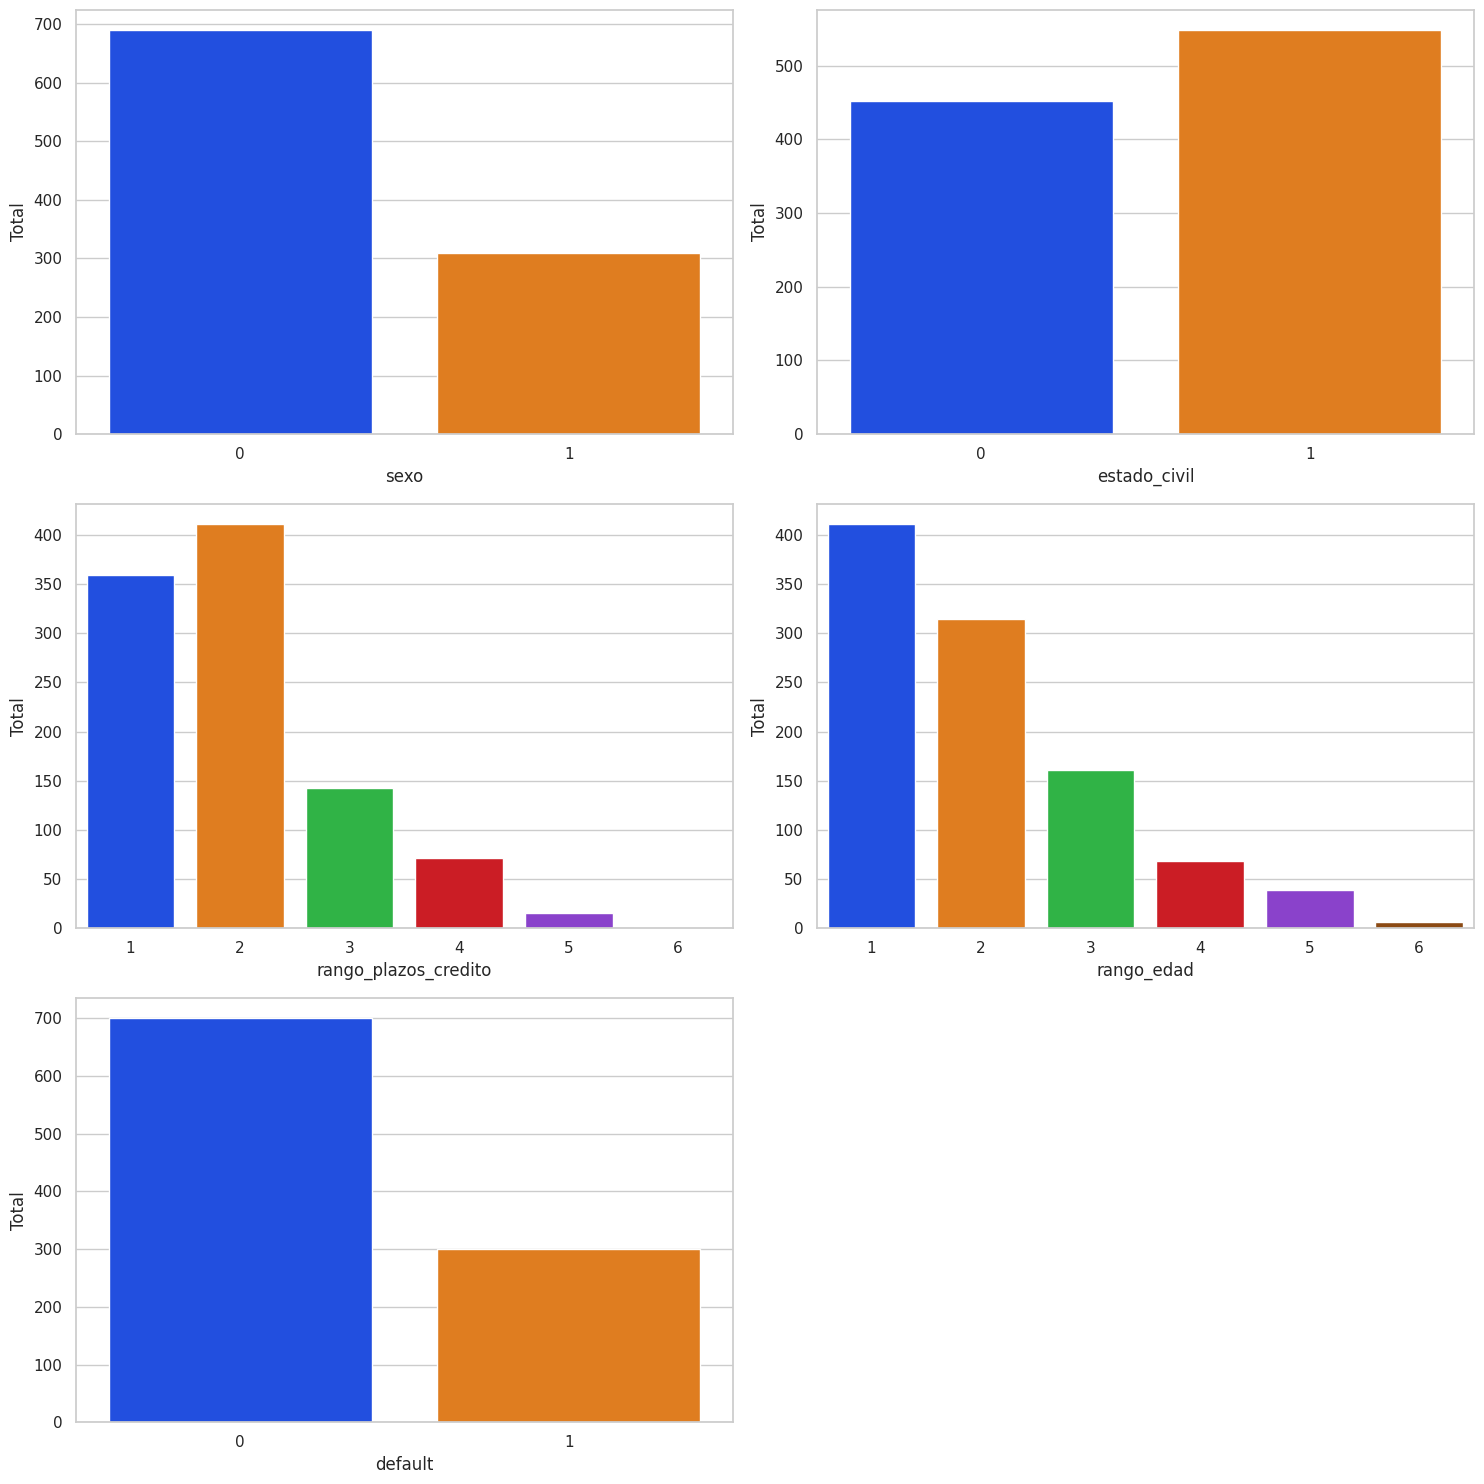

In [86]:
analisis_exploratorio()

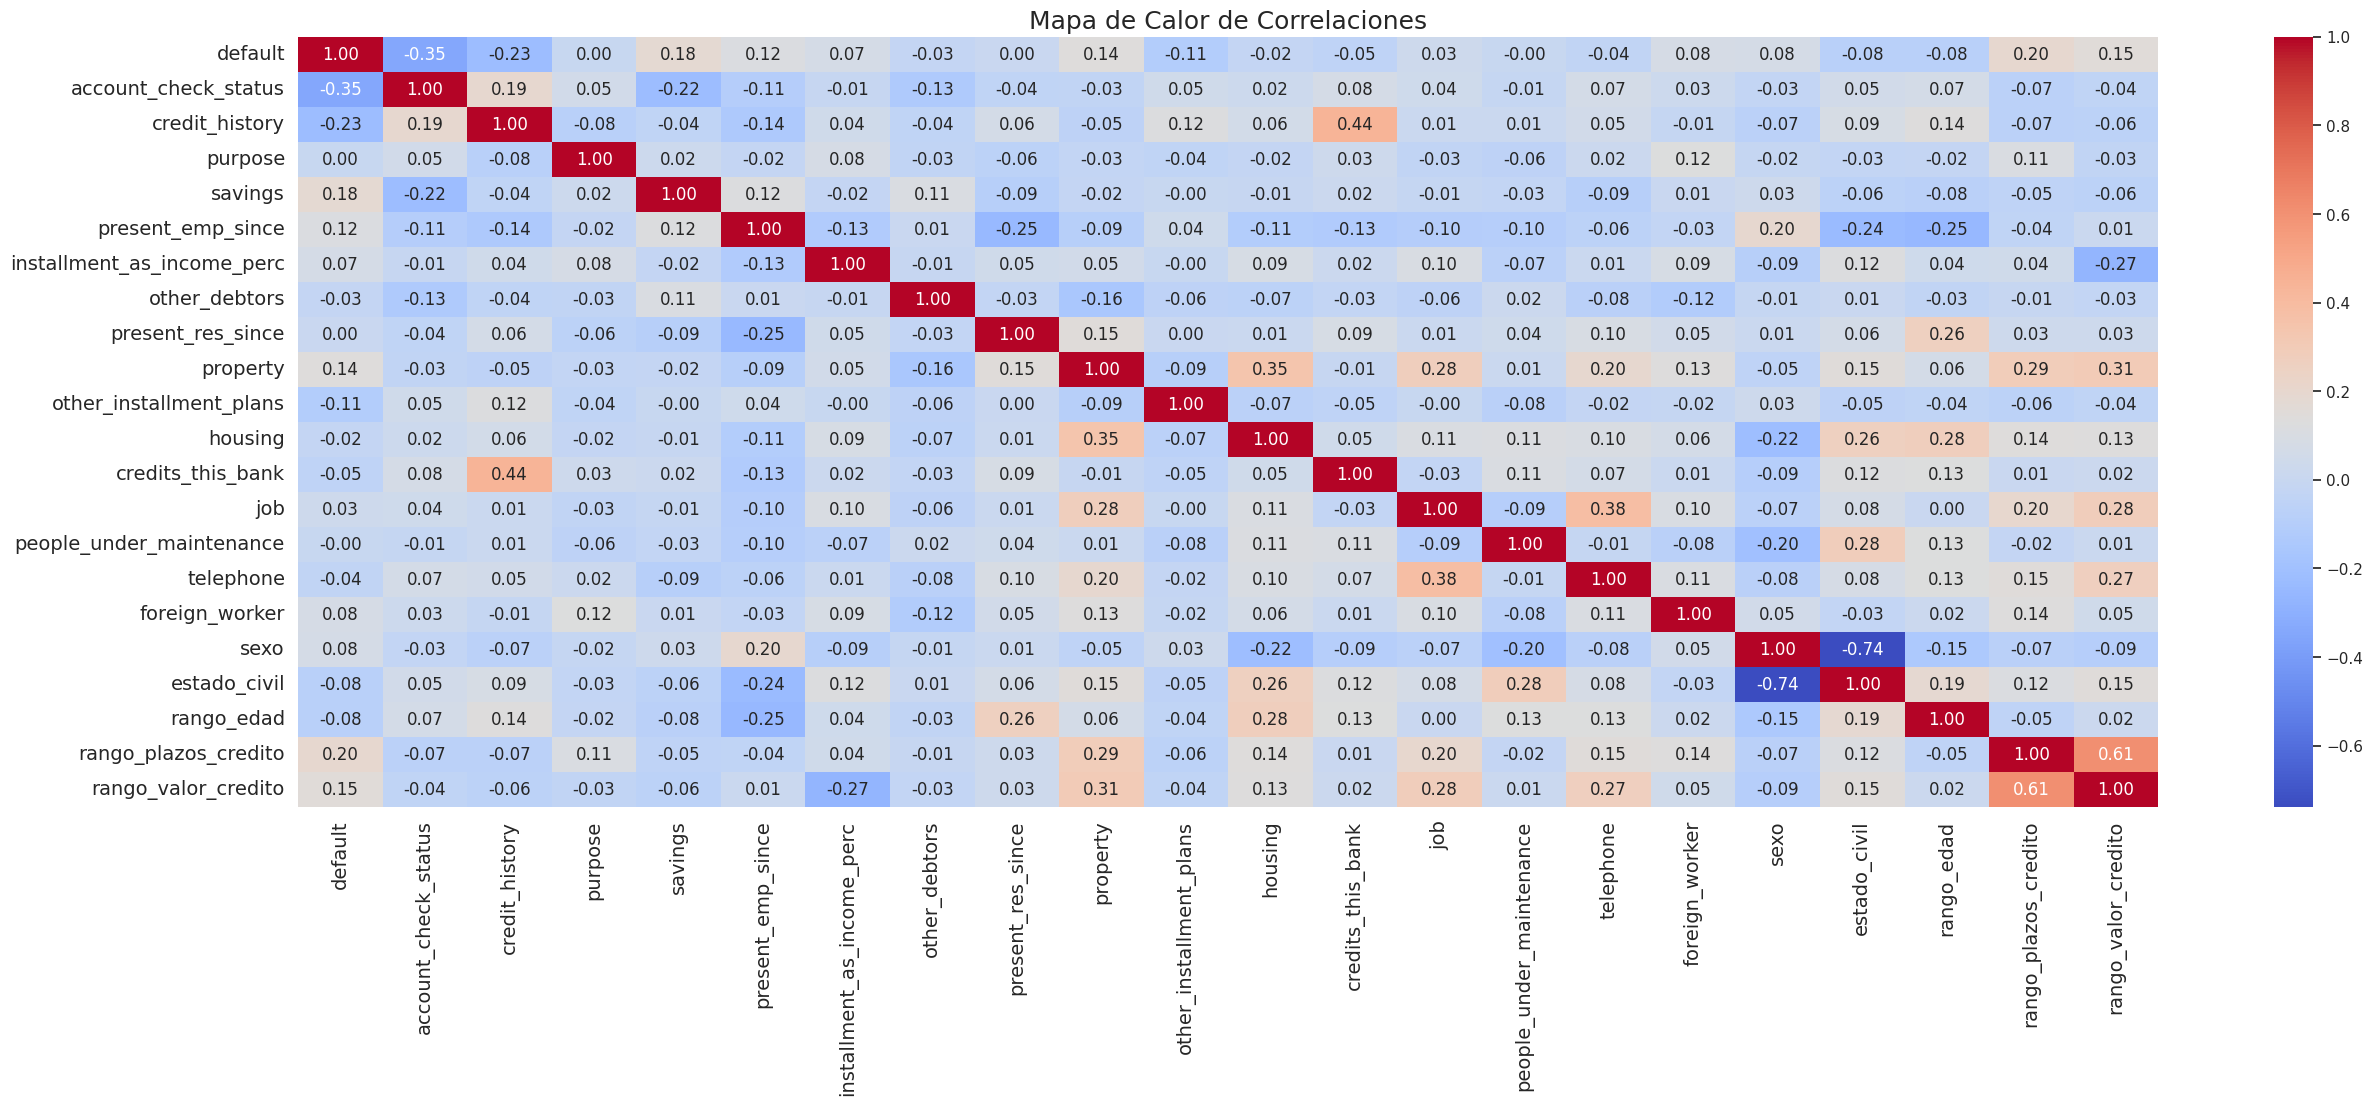

In [87]:
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_banco.corr(), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

In [88]:
print(df_banco.groupby(['estado_civil', 'sexo']).size())

estado_civil  sexo
0             0       142
              1       310
1             0       548
dtype: int64


#**4. Construcción de Modelos**


---


In [89]:
#creamos la funcion balancear_datos para balancear el numero de registros de la base
def balancear_datos():
  global df_banco, resultados  #variables globales

  #balanceo de datos
  #conteo de registros

  #base inicial
  ax = sns.countplot(x='default', data=df_banco)
  df_banco.default.value_counts()

  #dividiendo los datos en características y target
  X = df_banco.drop('default', axis = 1)
  y = df_banco['default']

  smt = SMOTE(random_state=123)
  X, y = smt.fit_resample(X, y)

  #unión de los datos balanceados
  df_banco = pd.concat([X, y], axis=1)

  #verificación 1 - unión de los datos
  df_banco.head(2)

  #verificación 2 - balanceamiento
  ax = sns.countplot(x='default', data=df_banco)

  df_banco.default.value_counts()


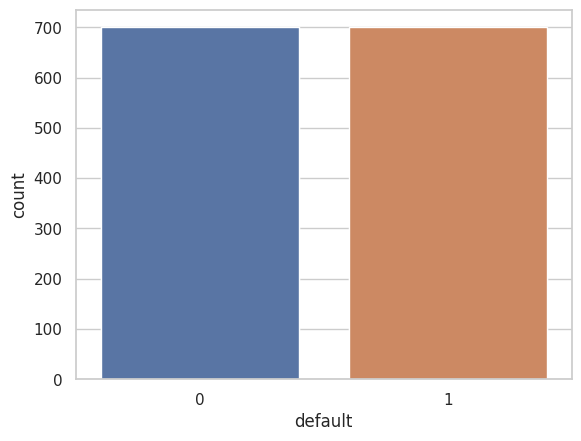

In [90]:
balancear_datos() #llamada de la funcion balancear_datos()
#función crea_modelos()
def crea_modelos():
  global df_banco, resultados  #variables globales

  #Separar en bases de entrenamiento y prueba
  y = df_banco['default']
  x = df_banco.drop(columns='default')
  train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.30, random_state = 77)

  #modelos ML
  modelos = [
        ('Regresión Logística', LogisticRegression()),
        ('Arbol de decisión', DecisionTreeClassifier()),
        ('Random Forest', RandomForestClassifier()),
        ('Naive Bayes', GaussianNB())
  ]
  #Listas para almacenar resultados
  nombres_modelos = []
  accuracy_list = []
  precision_list = []
  recall_list = []
  f1_score_list = []
  auc_roc_list = []

  #entrenamiento de modelos
  for nombre_modelo, model in modelos:
    #entrenar el modelo de ML
    model.fit(train_x, train_y)

    #realizar predicciones
    predictions = model.predict(test_x)

    #metricas de evaluación
    accuracy = accuracy_score(test_y, predictions)
    precision = precision_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    f1_score_value = f1_score(test_y, predictions)
    auc_roc = roc_auc_score(test_y, predictions)

    #guardar resultados en lista correspondiente
    nombres_modelos.append(nombre_modelo)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score_value)
    auc_roc_list.append(auc_roc)

    #guardar los resultados en el diccionario resultados
    resultados = {
        'Model': nombres_modelos,
        'Accuracy': accuracy_list,
        'Precision': precision_list,
        'Recall': recall_list,
        'F1_Score': f1_score_list,
        'AUC_ROC': auc_roc_list
    }

In [91]:
crea_modelos()
for i, model in enumerate(resultados['Model']):
    print(f"Modelo: {model}")
    print(f"Accuracy: {resultados['Accuracy'][i]}")
    print(f"Precisión: {resultados['Precision'][i]}")
    print(f"Recall: {resultados['Recall'][i]}")
    print(f"F1-score: {resultados['F1_Score'][i]}")
    print(f"AUC-ROC: {resultados['AUC_ROC'][i]}\n")

Modelo: Regresión Logística
Accuracy: 0.7690476190476191
Precisión: 0.7370892018779343
Recall: 0.7929292929292929
F1-score: 0.7639902676399025
AUC-ROC: 0.7703385203385203

Modelo: Arbol de decisión
Accuracy: 0.7285714285714285
Precisión: 0.7058823529411765
Recall: 0.7272727272727273
F1-score: 0.7164179104477613
AUC-ROC: 0.7285012285012286

Modelo: Random Forest
Accuracy: 0.8214285714285714
Precisión: 0.783410138248848
Recall: 0.8585858585858586
F1-score: 0.819277108433735
AUC-ROC: 0.8234370734370733

Modelo: Naive Bayes
Accuracy: 0.7095238095238096
Precisión: 0.6610169491525424
Recall: 0.7878787878787878
F1-score: 0.7188940092165897
AUC-ROC: 0.7137592137592138



#**5. Evaluación y Selección del Modelo**


---


In [92]:
#función visualiza_resultados()
def visualiza_resultados():
  global df_banco, resultados  #variables globales

  #se crea un dataframe con los resultados
  results_df = pd.DataFrame(resultados)
  results_df.set_index('Model', inplace=True)

  #visualizacion
  results_df = results_df.T
  colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']
  results_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0, color=colors)

  plt.title('Comparación de Métricas por Modelo')
  plt.xlabel('Métricas')
  plt.ylabel('Puntuación')
  plt.legend(title='Modelos', loc='right', bbox_to_anchor=(1.25, 0.5))
  plt.tight_layout()
  plt.show()


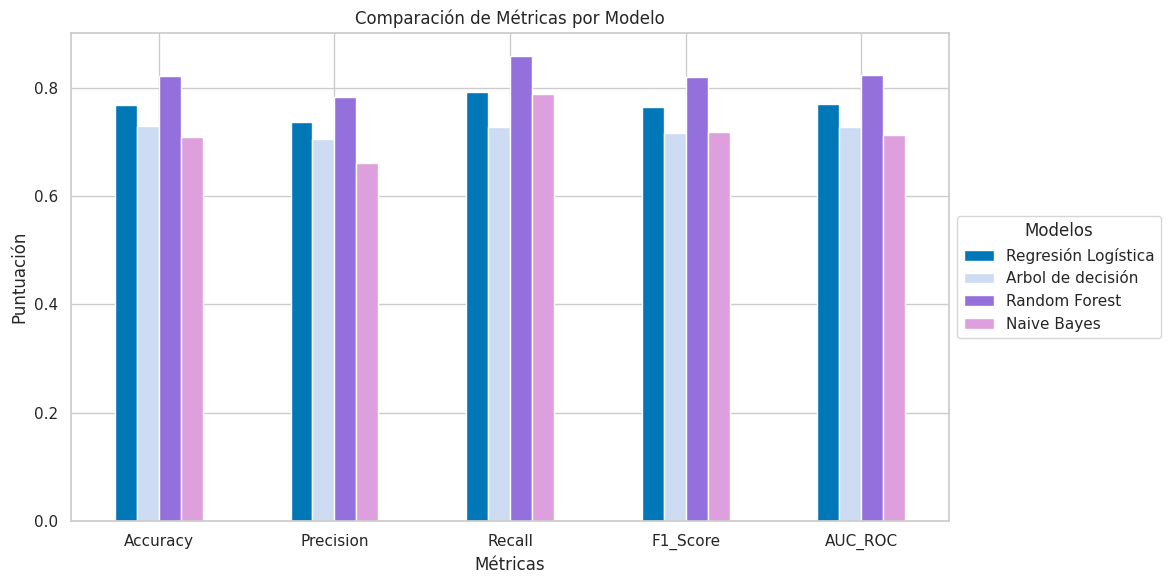

In [93]:
visualiza_resultados()

Mejor Modelo: Random Forest
Accuracy: 0.819047619047619
Precisión: 0.7772727272727272
Recall: 0.8636363636363636
F1-score: 0.8181818181818181
AUC-ROC: 0.8214578214578215


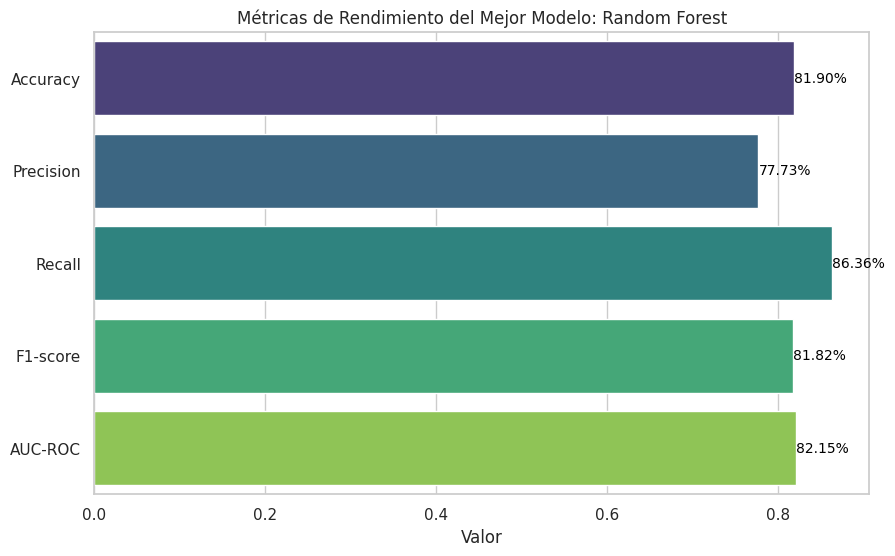

In [94]:
# Función para probar el mejor modelo
def probar_mejor_modelo():
    global df_banco, resultados  # Variables globales
    global y, x, train_x, test_x, train_y, test_y
    global accuracy, precision, recall, f1_score_value, auc_roc, mejor_modelo

    #modelo con mejor precisión
    mejor_modelo_idx = max(range(len(resultados['Precision'])), key=lambda i: resultados['Precision'][i])

    # Nombre del mejor modelo
    mejor_modelo = resultados['Model'][mejor_modelo_idx]

    #separar en bases de entrenamiento y prueba
    y = df_banco['default']
    x = df_banco.drop(columns='default')
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.30, random_state=77)

    #inicializar mejor modelo
    if mejor_modelo == 'Regresión Logística':
        model = LogisticRegression()
    elif mejor_modelo == 'Árbol de decisión':
        model = DecisionTreeClassifier()
    elif mejor_modelo == 'Random Forest':
        model = RandomForestClassifier()
    elif mejor_modelo == 'Naive Bayes':
        model = GaussianNB()

    #entrenar mejor modelo
    model.fit(train_x, train_y)

    #realizar predicciones
    predictions = model.predict(test_x)

    #Obtener metricas de evaluación del mejor modelo
    accuracy = accuracy_score(test_y, predictions)
    precision = precision_score(test_y, predictions)
    recall = recall_score(test_y, predictions)
    f1_score_value = f1_score(test_y, predictions)
    auc_roc = roc_auc_score(test_y, predictions)

    #mostrar métricas del mejor modelo
    print(f"Mejor Modelo: {mejor_modelo}")
    print(f"Accuracy: {accuracy}")
    print(f"Precisión: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1_score_value}")
    print(f"AUC-ROC: {auc_roc}")

    return model

# Llamar a la función para probar el mejor modelo
probar_mejor_modelo()

#gráfico de barras con etiquetas de valores
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']
values = [accuracy, precision, recall, f1_score_value, auc_roc]

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=values, y=metrics, palette='viridis')
plt.xlabel('Valor')
plt.title(f'Métricas de Rendimiento del Mejor Modelo: {mejor_modelo}')

for index, value in enumerate(values):
  bar_plot.text(value, index, f'{value*100:.2f}%', ha='left', va='center', fontsize=10, color='black')

plt.show()



Mejor Modelo: Random Forest
Accuracy: 0.8333333333333334
Precisión: 0.7909090909090909
Recall: 0.8787878787878788
F1-score: 0.8325358851674641
AUC-ROC: 0.8357903357903359


El nuevo cliente es un mal cliente



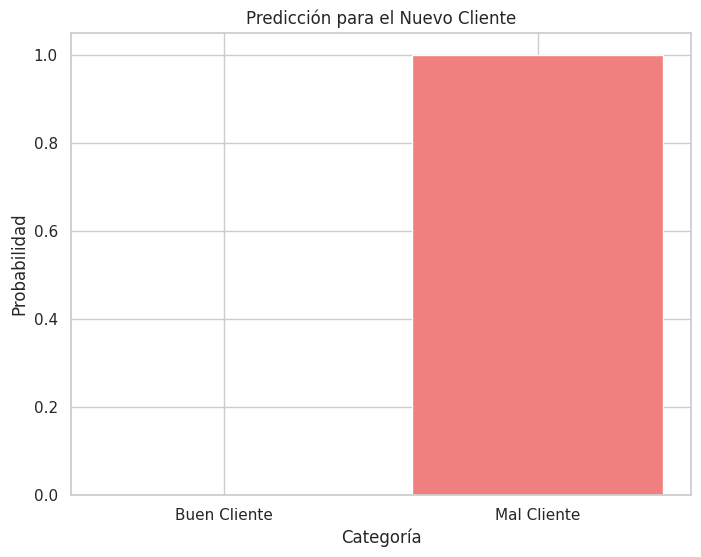

In [95]:
#probando el Modelo con un registro nuevo
def predecir_nuevo_cliente(modelo, nuevo_registro):
    # Convertir el nuevo registro a un DataFrame
    df_prediccion = pd.DataFrame([nuevo_registro])

    # Usar el modelo entrenado para predecir el resultado
    predicciones = modelo.predict(df_prediccion)

    return predicciones

#mejor modelo
best_model = probar_mejor_modelo()

# Nuevo registro para predicción
nuevo_registro = {
    'account_check_status': 1,
    'credit_history': 2,
    'purpose': 3,
    'savings': 4,
    'present_emp_since': 5,
    'installment_as_income_perc': 4,
    'other_debtors': 1,
    'present_res_since': 4,
    'property': 2,
    'other_installment_plans': 1,
    'housing': 3,
    'credits_this_bank': 2,
    'job': 2,
    'people_under_maintenance': 1,
    'telephone': 1,
    'foreign_worker': 1,
    'sexo': 1,
    'estado_civil': 0,
    'rango_edad': 3,
    'rango_plazos_credito': 2,
    'rango_valor_credito': 10
}

# Realizar la predicción
predicciones = predecir_nuevo_cliente(best_model, nuevo_registro)

# Imprimir la predicción
if predicciones == 0:
    print("\n\nEl nuevo cliente es un buen cliente")
else:
    print("\n\nEl nuevo cliente es un mal cliente\n")

# Visualizar la predicción con un gráfico de barras
labels = ['Buen Cliente', 'Mal Cliente']
values = [1 - predicciones[0], predicciones[0]]
colors = ['lightgreen', 'lightcoral']

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=colors)
plt.title('Predicción para el Nuevo Cliente')
plt.xlabel('Categoría')
plt.ylabel('Probabilidad')
plt.show()
